# MoreStructure
Kaggle score: 

References:
1. https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

## Run name

In [1]:
import time

project_name = 'DigitRecognizer'
step_name = 'MoreStructure'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = '%s_%s_%s' % (project_name, step_name, time_str)
print('run_name: %s' % run_name)
t0 = time.time()

run_name: DigitRecognizer_MoreStructure_20180416_213758


## Important Params

In [2]:
batch_size = 128
input_size = None
test_size = 0.05
random_state = None

## Import PKGs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display

import os
import gc
import math
import shutil
import zipfile
import pickle
import h5py
from PIL import Image

from tqdm import tqdm
from multiprocessing import cpu_count

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

### Basic folders

In [4]:
cwd = os.getcwd()
input_folder = os.path.join(cwd, 'input')
log_folder = os.path.join(cwd, 'log')
model_folder = os.path.join(cwd, 'model')
output_folder = os.path.join(cwd, 'output')
print('input_folder: \t\t%s' % input_folder)
print('log_folder: \t\t%s' % log_folder)
print('model_folder: \t\t%s' % model_folder)
print('output_folder: \t\t%s'% output_folder)

train_csv_file = os.path.join(input_folder, 'train.csv')
test_csv_file = os.path.join(input_folder, 'test.csv')
print('\ntrain_csv_file: \t%s' % train_csv_file)
print('test_csv_file: \t\t%s' % test_csv_file)

processed_data_file = os.path.join(input_folder, 'DigitRecognizer_Preprocess.p')
print('processed_data_file: \t%s' % processed_data_file)

input_folder: 		D:\Kaggle\digit-recognizer\input
log_folder: 		D:\Kaggle\digit-recognizer\log
model_folder: 		D:\Kaggle\digit-recognizer\model
output_folder: 		D:\Kaggle\digit-recognizer\output

train_csv_file: 	D:\Kaggle\digit-recognizer\input\train.csv
test_csv_file: 		D:\Kaggle\digit-recognizer\input\test.csv
processed_data_file: 	D:\Kaggle\digit-recognizer\input\DigitRecognizer_Preprocess.p


### Basic functions

In [5]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

In [6]:
def show_data_images(rows, fig_column, y_data, *args):
    columns = len(args)
    figs, axes = plt.subplots(rows, columns, figsize=(rows, fig_column*columns))
    print(axes.shape)  
    for i, ax in enumerate(axes):
        y_data_str = ''
        if type(y_data) != type(None):
            y_data_str =  '_' + str(y_data[i])
        ax[0].set_title('28x28' + y_data_str)
        for j, arg in enumerate(args):
            ax[j].imshow(arg[i])

### Load data

In [7]:
def save_data(x_data, y_data, x_test, file_name):
    if os.path.exists(file_name):
        os.remove(file_name)
        print('File removed: \t%s' % file_name)
    with h5py.File(file_name) as h:
        h.create_dataset('x_data', data=x_data)
        h.create_dataset('y_data', data=y_data)
        h.create_dataset('x_test', data=x_test)
    print('File saved: \t%s' % file_name)

def load_data(file_name):
    with h5py.File(file_name, 'r') as h:
        x_data = np.array(h['x_data'])
        y_data = np.array(h['y_data'])
        x_test = np.array(h['x_test'])
    print('File loaded: \t%s' % file_name)
    return x_data, y_data, x_test

In [8]:
%%time
x_data, y_data, x_test = load_data(processed_data_file)

print(x_data.shape)
print(y_data.shape)
print(x_test.shape)

File loaded: 	D:\Kaggle\digit-recognizer\input\DigitRecognizer_Preprocess.p
(42000, 28, 28)
(42000,)
(28000, 28, 28)
Wall time: 515 ms


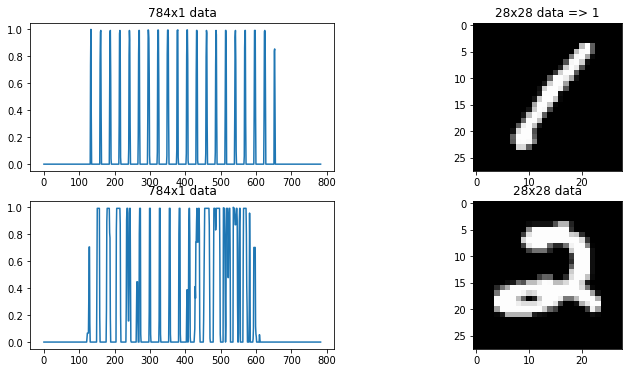

In [9]:
# Preview data
index = 0
fig, ax = plt.subplots(2, 2, figsize=(12,6))
ax[0, 0].plot(x_data[index].reshape(784,))
ax[0, 0].set_title('784x1 data')
ax[0, 1].imshow(x_data[index].reshape(28,28), cmap='gray')
ax[0, 1].set_title('28x28 data => ' + str(y_data[index]))

ax[1, 0].plot(x_test[index].reshape(784,))
ax[1, 0].set_title('784x1 data')
ax[1, 1].imshow(x_test[index].reshape(28,28), cmap='gray')
ax[1, 1].set_title('28x28 data')

plt.show()

In [10]:
x_data = x_data[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

## Resize images

In [11]:
if input_size == None:
    input_size = x_data.shape[1]

input_shape = (input_size, input_size, 1)
print('input_shape: ', input_shape)

input_shape:  (28, 28, 1)


In [12]:
from keras.utils.np_utils import to_categorical
print(y_data[0])
y_data = to_categorical(y_data)
# example:
print(y_data[0])

Using TensorFlow backend.


1
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=test_size, random_state=random_state)
describe(x_train)
describe(x_val)
describe(y_train)
describe(y_val)

(39900, 28, 28, 1) 0.0 1.0 250252944
(2100, 28, 28, 1) 0.0 1.0 13171344
(39900, 10) 0.0 1.0 3192112
(2100, 10) 0.0 1.0 168112


### Build model

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

In [15]:
def build_model(input_shape):
    model = Sequential()
    # Block 1
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding = 'Same', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.25))
    # Block 2
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.25))

    # Output
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(
        optimizer=Adam(lr=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [16]:
model = build_model(input_shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [17]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [18]:
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** x)

def get_lr(x):
    lr = round(3e-4 * 0.9 ** x, 12)
    if lr < 1e-12:
        lr = 1e-12
    print('%.12f' % lr, end=' ')
    return lr
annealer = LearningRateScheduler(get_lr)

# log_dir = os.path.join(log_path, run_name)
# print('log_dir:' + log_dir)
# tensorBoard = TensorBoard(log_dir=log_dir)

callbacks = []
# callbacks = [annealer]

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    channel_shift_range=20,
#     horizontal_flip=True,
#     vertical_flip=True,
    fill_mode='wrap'
)

val_datagen = ImageDataGenerator()

In [20]:
cpu_amount = cpu_count()
print(cpu_amount)

4


In [21]:
%%time
batch_size = 128
# steps_per_epoch = x_train.shape[0] / batch_size

hist = model.fit(
    x_data, 
    y_data, 
    batch_size=batch_size, 
    epochs=1, 
    verbose=2, 
    callbacks=callbacks, 
    validation_split=test_size, 
    validation_data=None, 
    shuffle=True, 
    class_weight=None, 
    sample_weight=None, 
    initial_epoch=0, 
    steps_per_epoch=None, 
    validation_steps=None
)

Train on 39900 samples, validate on 2100 samples
Epoch 1/1
 - 84s - loss: 0.4473 - acc: 0.8571 - val_loss: 0.0936 - val_acc: 0.9714
Wall time: 1min 27s


In [22]:
# %%time
# batch_size = 128
# # steps_per_epoch = x_train.shape[0] / batch_size

# hist = model.fit_generator(
#     train_datagen.flow(x_train, y_train, batch_size=batch_size, seed=random_state),
# #     steps_per_epoch=steps_per_epoch,
#     epochs=20, #Increase this when not on Kaggle kernel
#     verbose=1,  #1 for ETA, 0 for silentrandom_state
#     callbacks=callbacks,
#     max_queue_size=batch_size,
#     workers=cpu_amount,
#     validation_steps=1000,
#     validation_data=val_datagen.flow(x_val, y_val, batch_size=32, seed=random_state)
# )

In [23]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0815, final accuracy: 0.9705


In [24]:
final_acc_str = '{0:0>4}'.format(int(final_acc*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

DigitRecognizer_MoreStructure_20180416_213758_9704


In [25]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_folder, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


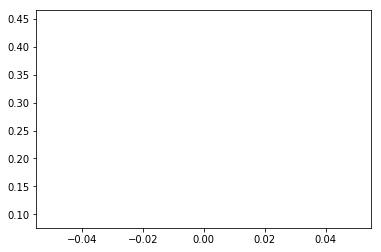

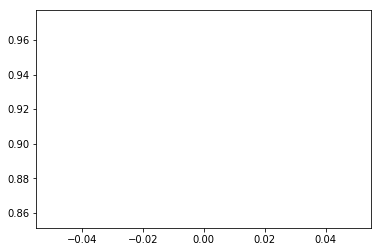

In [26]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [27]:
saveModel(model, run_name_acc)

In [28]:
# y_hat = model.predict(x_val)
# y_pred = np.argmax(y_hat, axis=1)
# y_true = np.argmax(y_val, axis=1)
# cm = confusion_matrix(y_true, y_pred)
# print(cm)

accuracy_score: 0.970476190476
[[209   0   0   0   0   0   2   0   0   0]
 [  0 253   1   1   0   0   1   1   1   0]
 [  0   2 196   2   1   1   1   3   1   0]
 [  2   1   2 213   0   0   0   2   1   1]
 [  0   0   0   0 200   0   0   0   0   4]
 [  0   0   0   0   0 202   2   0   2   0]
 [  1   0   0   0   0   2 170   0   0   0]
 [  0   2   1   0   2   1   0 204   0   4]
 [  3   0   0   0   0   0   1   1 196   1]
 [  1   0   0   1   4   2   0   0   0 195]]
count: 62
(62,)


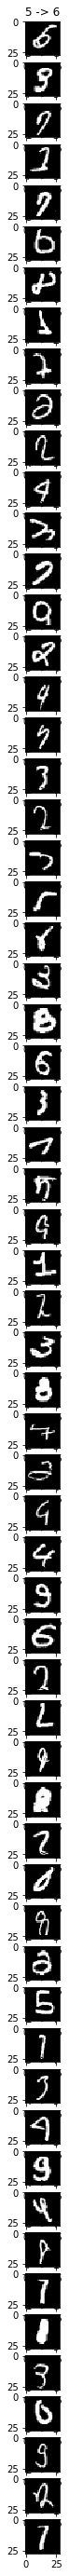

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
def show_diffs(model, x_data, y_data, labels):
    y_hat = model.predict(x_data)
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_data, axis=1)
    print('accuracy_score: %s' % accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, labels)
    print(cm)
    indexes = []
    diffs = []
    for i, p in enumerate(zip(y_true, y_pred)):
        if p[0] != p[1]:
            indexes.append(i)
            diffs.append(p)
    count = len(indexes)
    print('count: %s' % count)
    figs, axes = plt.subplots(count, 1, figsize=(count,50))
    print(axes.shape)
    for i, p in enumerate(diffs):
        axes[i].imshow(x_val[indexes[i]].reshape(28, 28), cmap='gray')
        axes[i].set_title('%s -> %s' % (p[0], p[1]))
        
show_diffs(model, x_val, y_val, labels=list(range(0, 10)))

## Predict

In [30]:
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
pred_file = os.path.join(output_folder, run_name_acc + '.csv')
print(pred_file)

D:\Kaggle\digit-recognizer\output\DigitRecognizer_MoreStructure_20180416_213758_9704.csv


In [ ]:
y_data_proba = model.predict(x_data, batch_size=batch_size)
print('y_data_proba.shape: ', y_data_proba.shape)

y_data_proba.shape:  (42000, 10)


In [ ]:
y_test_proba = model.predict(x_test, batch_size=batch_size)
print('y_test_proba.shape: ', y_test_proba.shape)

In [ ]:
def save_proba(y_data_proba, y_data, y_test_proba, file_name):
    if os.path.exists(file_name):
        os.remove(file_name)
        print('File removed: \t%s' % file_name)
    with h5py.File(file_name) as h:
        h.create_dataset('y_data_proba', data=y_data_proba)
        h.create_dataset('y_data', data=y_data)
        h.create_dataset('y_test_proba', data=y_test_proba)
    print('File saved: \t%s' % file_name)

def load_proba(file_name):
    with h5py.File(file_name, 'r') as h:
        y_data_proba = np.array(h['y_data_proba'])
        y_data = np.array(h['y_data'])
        y_test_proba = np.array(h['y_test_proba'])
    print('File loaded: \t%s' % file_name)
    
    return y_data_proba, y_data, y_test_proba


y_proba_file = os.path.join(model_folder, '%s.p' % run_name_acc)
save_proba(y_data_proba, y_data, y_test_proba, y_proba_file)
y_data_proba, y_data, y_test_proba = load_proba(y_proba_file)

print(y_data_proba.shape)
print(y_data.shape)
print(y_test_proba.shape)

In [ ]:
y_test_pred = np.argmax(y_test_proba, axis=1)
print('y_test_pred.shape: ', y_test_pred.shape)

with open(pred_file, 'w') as f:
    f.write('ImageId,Label\n')
    for i in range(len(y_test_pred)) :
        f.write("".join([str(i+1),',',str(y_test_pred[i]),'\n']))

In [ ]:
print(run_name_acc)

t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')